<a href="https://colab.research.google.com/github/Sahanaka/SER-EE7209_G14/blob/main/speech_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Emotion Recognition**
In this notebook we will experiment SER on a small subset of RAVDESS dataset.

## **Setup**

## **Imports**

In [48]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## **Data Preparation**

### Feature Loading

In [2]:
# LOAD THE DATA FRAME FROM CSV

# NOTE: PLEASE UNCOMMENT ONE AT A TIME TO LOAD THE RELEVENT DATA FRAME

df_combined = pd.read_csv('https://raw.githubusercontent.com/Sahanaka/SER-EE7209_G14/main/Features/combined_extracted_features.csv')
# df_combined = pd.read_csv('https://raw.githubusercontent.com/Sahanaka/SER-EE7209_G14/main/Features/mfcc.csv')
# df_combined = pd.read_csv('https://raw.githubusercontent.com/Sahanaka/SER-EE7209_G14/main/Features/mel_spectogram.csv')
# df_combined = pd.read_csv('https://raw.githubusercontent.com/Sahanaka/SER-EE7209_G14/main/Features/contrast.csv')
# df_combined = pd.read_csv('https://raw.githubusercontent.com/Sahanaka/SER-EE7209_G14/main/Features/chroma.csv')
# df_combined = pd.read_csv('https://raw.githubusercontent.com/Sahanaka/SER-EE7209_G14/main/Features/zcr.csv')

In [3]:
df_combined.drop(columns='path', inplace=True)
df_combined.head()

,Unnamed: 0,emotion,actor,0,1,2,3,4,5,6,...,249.3,250.3,251.3,252.3,253.3,254.3,255.3,256.3,257.3,258.3
0,0,neutral,1,-696.20105,78.316574,3.646741,13.573399,7.353319,14.752226,-4.387536,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,neutral,1,-686.31300,78.732320,0.704220,14.193933,9.702352,14.567476,-5.940362,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,neutral,1,-690.26385,80.471260,3.066295,13.347497,6.988072,11.344915,-4.785039,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,neutral,1,-688.70215,78.576100,5.858980,15.703995,7.521081,13.692708,-3.470273,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,calm,1,-727.78330,87.151090,5.981501,16.521162,7.651807,15.974822,-4.892543,...,0.070312,0.121094,0.192383,0.204102,0.260254,0.184082,0.202148,0.203125,0.133789,0.101562


### Data Preparation for modeling

In [4]:
# TRAIN, VALIDATION & TEST SPLITS

def create_data_splits(data_frame, split_size):
  # TRAIN TEST SPLIT DATA
  train_set, test_set = train_test_split(data_frame, test_size=split_size, random_state=42,
                               stratify=data_frame[['emotion', 'actor']])
  # TRAIN VALIDATION SPLIT
  train_set, validation_set = train_test_split(train_set, test_size=0.2, random_state=42)

  return train_set, validation_set, test_set

In [5]:
train, validation, test = create_data_splits(df_combined, split_size=0.2)

In [6]:
print(train.shape)
print(validation.shape)
print(test.shape)

(921, 1052)
(231, 1052)
(288, 1052)


In [7]:
# SEPERATE FEATURES AND LABELS

def create_features_labels_arrays(train, validation, test):
  # Training set
  X_train = train.iloc[:, 3:]
  y_train = train.iloc[:,1]

  # Testing set
  X_test = test.iloc[:,3:]
  y_test = test.iloc[:,1]

  # Validation set
  X_validation = validation.iloc[:,3:]
  y_validation = validation.iloc[:,1]

  return X_train, y_train, X_test, y_test, X_validation, y_validation

In [8]:
X_train, y_train, X_test, y_test, X_validation, y_validation = create_features_labels_arrays(train, validation, test)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(921, 1049)
(288, 1049)
(231, 1049)


### Data Preprocessing

In [10]:
# NORMALIZE DATA

def normalize(X_train, X_test, X_validation):
  mean = np.mean(X_train, axis=0)
  std = np.std(X_train, axis=0)
  X_train = (X_train - mean) / std
  X_test = (X_test - mean) / std
  X_validation = (X_validation - mean) /std
  return X_train, X_validation, X_test

In [11]:
X_train, X_validation, X_test = normalize(X_train, X_test, X_validation)

In [12]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,249.3,250.3,251.3,252.3,253.3,254.3,255.3,256.3,257.3,258.3
1036,1.595679,-2.436616,-1.514227,-1.964854,-1.451400,-1.361762,-0.145686,-1.086007,0.908590,-1.193488,...,-0.491792,-0.559748,-0.092088,0.192592,0.542643,0.763745,0.676921,0.344159,0.166146,-0.133400
1225,0.847454,1.913956,-0.546146,-0.427904,1.402261,1.207891,-0.360267,-2.791007,0.741631,-1.555200,...,-0.296808,-0.157306,0.190579,0.413362,0.722922,0.791900,0.835001,0.800745,0.776432,0.762948
372,-0.828193,1.780544,0.445339,0.540923,1.429144,1.121802,0.644818,0.624466,0.527090,0.857312,...,0.290780,0.382813,0.570086,0.486952,0.583849,0.694635,0.804405,0.758097,0.729487,0.578767
211,0.188013,-0.782151,-0.651782,-0.477900,-0.875524,-1.542397,-0.271836,-0.378563,-1.006165,-0.937283,...,0.846748,0.859388,1.297692,1.569772,1.351326,1.362695,1.107816,1.187087,1.184268,1.098567
1018,1.233247,-1.432905,0.406614,0.867307,-0.157041,-0.046907,1.231033,0.912411,1.659086,1.430035,...,-0.001697,0.041267,0.002134,-0.283113,-1.172589,-1.173887,-1.174144,-1.120929,-1.121910,-1.111606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,-0.909045,0.763324,0.304035,-0.153044,0.597637,0.695800,1.327875,-0.437637,1.247748,-0.079157,...,-1.298078,-1.290497,-1.248930,-1.242408,-1.172589,-1.173887,-1.174144,-1.120929,-1.121910,-1.111606
1,-1.021537,0.024106,0.584049,0.221343,1.319719,0.648275,0.944021,0.520806,0.921063,0.069673,...,-1.298078,-1.290497,-1.248930,-1.242408,-1.172589,-1.173887,-1.174144,-1.120929,-1.121910,-1.111606
154,2.508080,0.628506,-1.373030,0.273102,-1.129686,-1.044361,-0.464840,0.657391,-0.946206,-0.111078,...,-1.092554,-1.179296,-1.123300,-1.000613,-0.716739,-0.469992,-0.200168,0.045623,0.136805,0.230870
1102,-1.301408,1.333994,1.197735,0.772549,0.449023,0.933873,2.667472,1.371381,-0.130973,-0.046221,...,-1.298078,-1.290497,-1.248930,-1.242408,-1.172589,-1.173887,-1.174144,-1.120929,-1.121910,-1.111606


In [13]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,249.3,250.3,251.3,252.3,253.3,254.3,255.3,256.3,257.3,258.3
950,0.372401,-0.291995,0.754095,0.957032,-0.532724,-0.093363,-1.059571,-0.595938,-0.812016,-0.421142,...,0.989034,0.748187,0.899864,1.267529,1.098934,1.022266,0.914041,0.828341,0.811641,0.959408
591,1.647490,0.026977,-0.508224,-0.908246,-1.181309,-0.858178,-2.384094,-0.063995,-1.585490,-0.843484,...,-1.145253,-1.136934,-1.099744,-1.087344,-1.028366,-1.027988,-1.026262,-0.972915,-0.963470,-0.956075
840,-0.602793,0.996723,0.712110,-0.217379,1.142873,0.664544,0.765531,0.468729,1.752123,0.666716,...,-1.298078,-1.290497,-1.248930,-1.242408,-1.172589,-1.173887,-1.174144,-1.120929,-1.121910,-1.111606
1275,-0.604024,-0.263504,0.381322,-0.424450,-1.035249,0.704154,0.168339,-0.382940,-0.262145,-0.345274,...,-0.196681,-0.080525,0.389493,0.818105,0.625056,0.305573,0.014005,-0.074796,-0.077382,0.083525
565,0.054742,0.628870,0.133649,-0.065032,0.942717,0.816219,-0.718918,-0.143999,-1.570942,-1.542290,...,0.612240,0.674053,0.376406,0.092721,-0.229984,-0.510945,-0.682056,-0.706991,-0.719943,-0.702315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1.831940,-0.354668,-0.633629,-0.620799,0.603217,0.169698,-0.215945,0.706869,1.490545,-0.364853,...,-0.794808,-0.993961,-0.947942,-0.559075,-0.518432,-0.452074,-0.138975,-0.072287,0.104531,0.484630
748,-0.363650,0.335225,0.297418,0.029471,0.766451,0.141030,0.670122,0.187771,1.093246,0.331532,...,-0.512871,-0.673596,-0.654805,-0.856062,-1.172589,-1.173887,-1.174144,-1.120929,-1.121910,-1.111606
370,-0.405751,1.987946,1.081888,1.991811,0.674501,1.863644,-0.193193,-0.032893,-0.190440,0.500597,...,-1.250650,-1.226953,-1.191350,-1.184588,-1.115930,-1.107337,-1.072157,-0.965388,-0.934130,-0.906960
1300,0.717548,-1.212566,-1.467532,-1.037073,-1.538852,-1.162272,-0.741687,-2.216287,-0.506326,-1.149189,...,0.222272,0.356336,0.420900,0.431759,0.532341,0.489865,0.419404,0.321581,0.283509,0.177662


In [14]:
X_validation

,0,1,2,3,4,5,6,7,8,9,...,249.3,250.3,251.3,252.3,253.3,254.3,255.3,256.3,257.3,258.3
55,-0.839537,-0.285711,0.427719,0.106856,0.176281,-0.156627,0.355157,0.316719,0.425986,0.412805,...,-1.298078,-1.290497,-1.248930,-1.242408,-1.172589,-1.173887,-1.174144,-1.120929,-1.121910,-1.111606
1189,-0.063992,-1.347501,-0.385959,-0.477053,-1.056851,-0.857857,-0.756275,-0.441079,-0.322274,-0.266617,...,0.904717,0.875274,0.837049,0.481695,0.491134,0.715112,0.595331,0.645205,0.327520,0.087618
440,-1.111212,0.181096,1.470441,1.122497,1.037866,1.250657,0.379080,1.833274,-0.454748,1.333053,...,-1.161062,-1.279906,-1.248930,-1.242408,-0.786276,-0.759228,-0.636162,-0.483716,-0.819701,-0.735058
1118,-0.238642,-0.615069,-0.574581,1.717313,-0.516174,0.606042,1.397882,1.014251,-1.506275,0.716846,...,-0.170332,-0.369117,0.253394,0.345028,0.856844,1.214237,1.038975,1.274892,1.304565,1.237726
777,-0.489759,-0.212926,0.950158,0.222769,0.530484,0.652340,1.640699,-0.190333,0.849345,1.345797,...,-1.298078,-1.290497,-1.248930,-1.242408,-1.172589,-1.173887,-1.174144,-1.120929,-1.121910,-1.111606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,1.646645,-2.486877,-1.891034,-2.032905,-1.649258,-1.405369,-0.473062,-1.459623,0.364726,-1.352214,...,0.931066,1.057961,0.978383,0.610477,0.568397,0.113601,0.072648,0.048131,-0.021634,0.095803
800,-1.094054,-0.332701,0.745904,1.275663,0.316489,-0.474604,-0.251018,0.199853,-0.885497,1.266447,...,1.516019,1.809892,1.957249,1.882529,1.951399,1.541869,1.337287,1.435449,1.345642,1.573345
636,-0.657109,0.151086,1.188313,1.538991,0.170830,0.847360,1.414909,1.447360,1.582973,1.532776,...,-1.108364,-0.668301,-0.623398,-0.619523,-0.742494,-1.161089,-1.171594,-1.120929,-1.121910,-1.111606
1334,-0.305617,-0.444244,-0.068337,-0.336429,-0.096675,0.634270,0.056974,-0.285175,0.545465,-0.658493,...,-1.298078,-1.290497,-1.248930,-1.242408,-1.172589,-1.173887,-1.174144,-1.120929,-1.121910,-1.111606


In [15]:
# TURN DATA INTO ND ARRAYS FOR KERAS

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

In [16]:
# ONE HOT ENCODE THE TARGET

lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
y_validation = to_categorical(lb.fit_transform(y_validation))

In [17]:
print(y_train[0:10])
print(y_test[0:10])
print(y_validation[0:10])

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [18]:
X_train.shape

(921, 1049)

In [19]:
X_test.shape

(288, 1049)

In [20]:

X_validation.shape

(231, 1049)

## **Model Building**

### ANN Approach

In [21]:
model_3 = Sequential()

###first layer
model_3.add(Dense(10,input_shape=(X_train.shape[1],)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.1))

###second layer
model_3.add(Dense(1024))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.1))

###final layer
model_3.add(Dense(8))
model_3.add(Activation('softmax'))


In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_3.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                10500     
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1024)              11264     
                                                                 
 activation_1 (Activation)   (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 8

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=15)

In [24]:

history = model_3.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100, callbacks=[early_stop])

Epoch 1/100
29/29 [==============================] - 5s 20ms/step - loss: 2.0608 - accuracy: 0.1357 - val_loss: 2.0204 - val_accuracy: 0.1861
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 2.0009 - accuracy: 0.2096 - val_loss: 1.9540 - val_accuracy: 0.2554
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 1.9222 - accuracy: 0.2780 - val_loss: 1.8670 - val_accuracy: 0.3160
Epoch 4/100
29/29 [==============================] - 0s 8ms/step - loss: 1.8223 - accuracy: 0.3138 - val_loss: 1.7849 - val_accuracy: 0.3333
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 1.7503 - accuracy: 0.3333 - val_loss: 1.7245 - val_accuracy: 0.3247
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 1.6929 - accuracy: 0.3561 - val_loss: 1.6818 - val_accuracy: 0.3506
Epoch 7/100
29/29 [==============================] - 0s 8ms/step - loss: 1.6468 - accuracy: 0.3757 - val_loss: 1.6453 - val_accuracy: 0.3636
Epoch 8/100


In [25]:
model_3.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 1.4848 - accuracy: 0.4653


[1.4848076105117798, 0.4652777910232544]

In [26]:
metrics = pd.DataFrame(history.history)

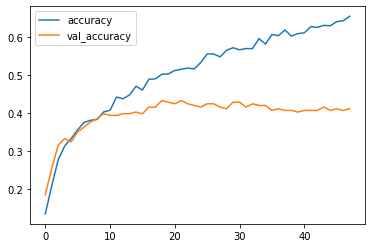

In [27]:
metrics[['accuracy', 'val_accuracy']].plot()

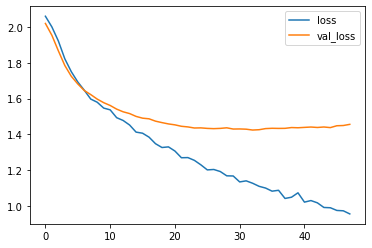

In [28]:
metrics[['loss', 'val_loss']].plot()

In [49]:
model3_pred = model_3.predict(X_test)
y_pred = np.argmax(model3_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
# y_test = np.argmax(y_test, axis=1)

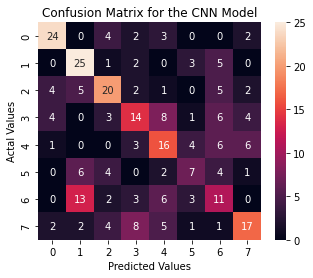

In [50]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for the CNN Model')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### CNN Approach

In [29]:
# ADD NEW DIMENSIONS
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_validation = X_validation[:,:,np.newaxis]

In [30]:
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(921, 1049, 1)
(288, 1049, 1)
(231, 1049, 1)


In [31]:
# BUILD 1D CNN LAYERS
model_cnn = tf.keras.Sequential()
model_cnn.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model_cnn.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(MaxPooling1D(pool_size=(8)))
model_cnn.add(Dropout(0.4))
model_cnn.add(Conv1D(128, kernel_size=(10),activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=(8)))
model_cnn.add(Dropout(0.4))
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dropout(0.4))
model_cnn.add(Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model_cnn.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1040, 64)          704       
                                                                 
 conv1d_1 (Conv1D)           (None, 1031, 128)         82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 128, 128)         0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 119, 128)          163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 14, 128)          0         
 1D)                                                  

In [32]:
cnn_model_history = model_cnn.fit(X_train, y_train,batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/100
29/29 [==============================] - 9s 28ms/step - loss: 2.6954 - accuracy: 0.2030 - val_loss: 2.2860 - val_accuracy: 0.3681
Epoch 2/100
29/29 [==============================] - 0s 11ms/step - loss: 2.1418 - accuracy: 0.3312 - val_loss: 1.9038 - val_accuracy: 0.4028
Epoch 3/100
29/29 [==============================] - 0s 12ms/step - loss: 1.8438 - accuracy: 0.3702 - val_loss: 1.7691 - val_accuracy: 0.3958
Epoch 4/100
29/29 [==============================] - 0s 12ms/step - loss: 1.6891 - accuracy: 0.3974 - val_loss: 1.6649 - val_accuracy: 0.3958
Epoch 5/100
29/29 [==============================] - 0s 12ms/step - loss: 1.5790 - accuracy: 0.4430 - val_loss: 1.5977 - val_accuracy: 0.4549
Epoch 6/100
29/29 [==============================] - 0s 11ms/step - loss: 1.5124 - accuracy: 0.4506 - val_loss: 1.5636 - val_accuracy: 0.4097
Epoch 7/100
29/29 [==============================] - 0s 12ms/step - loss: 1.4624 - accuracy: 0.4691 - val_loss: 1.4954 - val_accuracy: 0.4757
Epoch 

In [33]:
model_cnn.evaluate(X_test, y_test)

9/9 [==============================] - 0s 6ms/step - loss: 1.4325 - accuracy: 0.6181


[1.4324679374694824, 0.6180555820465088]

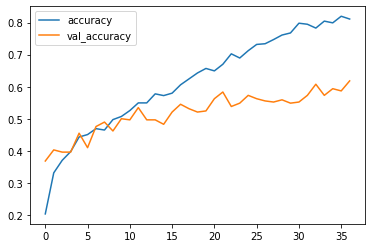

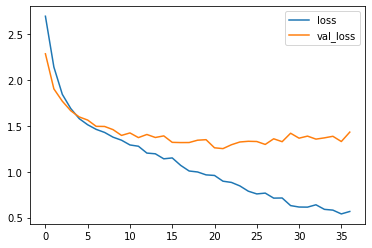

In [34]:
metrics = pd.DataFrame(cnn_model_history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [39]:
model_cnn_pred = model_cnn.predict(X_test)
type(model_cnn_pred)

numpy.ndarray

In [40]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [42]:
y_pred = np.argmax(model_cnn_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [43]:
cm = confusion_matrix(y_test, y_pred)

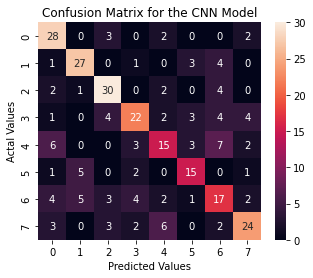

In [46]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for the CNN Model')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# f = sns.heatmap(cm, annot=True, fmt='d')